In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

In [97]:
df = pd.read_csv('/Users/YaoJunyan/Documents/A collection of Data Science take-home challenge/Employee Retention/employee_retention_data.csv')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [99]:
## quit_date column has some missing data by nature

In [100]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


### Question 1: Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.

In [101]:
#default NA value to 2015/12/13
df['quit_date']= df['quit_date'].fillna('2015-12-13')
#calculate the employee days
df['quit_date'] = pd.to_datetime(df['quit_date'])
df['join_date'] = pd.to_datetime(df['join_date'])

In [102]:
df['days'] = (df['quit_date'] - df['join_date']).dt.days

In [103]:
uniqlo_date =  pd.DataFrame(pd.date_range(start = '2011-01-24', end = '2015-12-13', freq= 'D'), columns= ['date'])

In [104]:
unique_companies =  pd.DataFrame(df['company_id'].unique())
unique_companies.columns = ['companies']

In [105]:
#create a table with all combinations of days and companies only for now by cross join two list
tbl = uniqlo_date.assign(foo = 1).merge(unique_companies.assign(foo=1)).drop('foo', 1)
tbl['employee_headcount'] = 0

In [106]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,days
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-13,426
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040


In [107]:
tbl.head()

,date,companies,employee_headcount
0,2011-01-24,7,0
1,2011-01-24,4,0
2,2011-01-24,2,0
3,2011-01-24,9,0
4,2011-01-24,1,0


In [108]:
for i, row in df.iterrows():
    tbl.loc[(tbl.date >= row.join_date) & (tbl.date <= row.quit_date) & (tbl.companies == row.company_id), 'employee_headcount'] += 1

In [109]:
tbl.sample(10)

,date,companies,employee_headcount
19297,2015-06-20,4,903
5500,2012-04-26,1,1996
16999,2014-12-10,5,768
4338,2012-01-20,10,174
15388,2014-07-29,1,3725
16038,2014-09-21,10,383
6325,2012-07-04,4,558
19556,2015-07-11,3,1220
19416,2015-06-30,7,533
20903,2015-10-31,12,12


### Question 2: What are the main factors that drive employee churn? Do they make sense? Explain your findings.


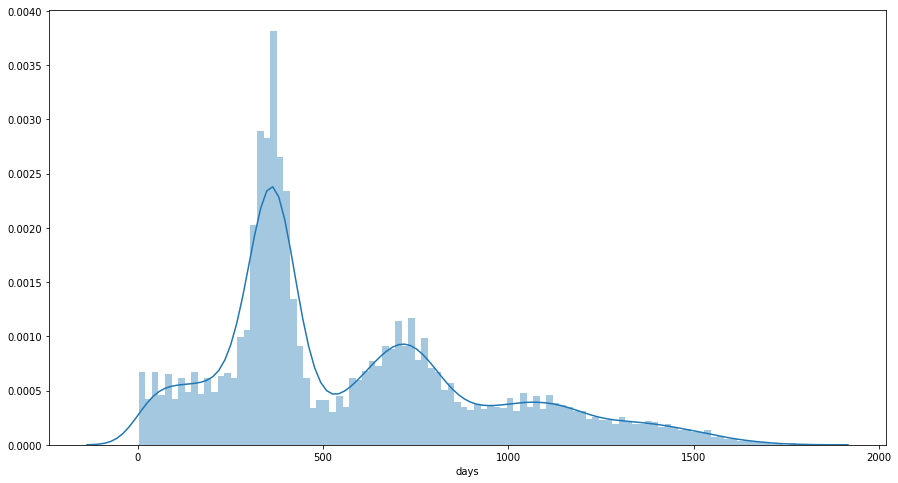

In [157]:
fig,ax = plt.subplots(figsize =(15,8))
sns.distplot(df.days, bins =100)
plt.show()

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 8 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      24702 non-null datetime64[ns]
days           24702 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 1.5+ MB


In [112]:
df['weeks_of_year'] = df['quit_date'].dt.week

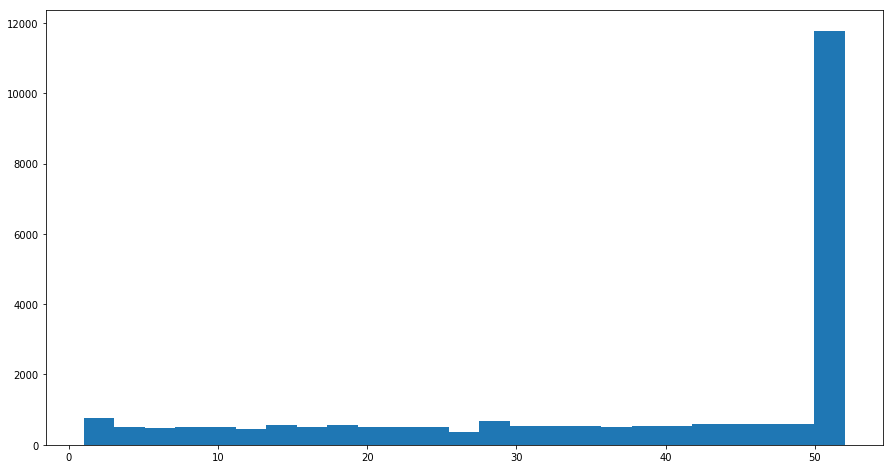

In [113]:
fig, ax = plt.subplots(figsize= (15,8))
plt.hist(df.weeks_of_year, bins=25)
plt.show()

In [114]:
## Most of people quit at year end

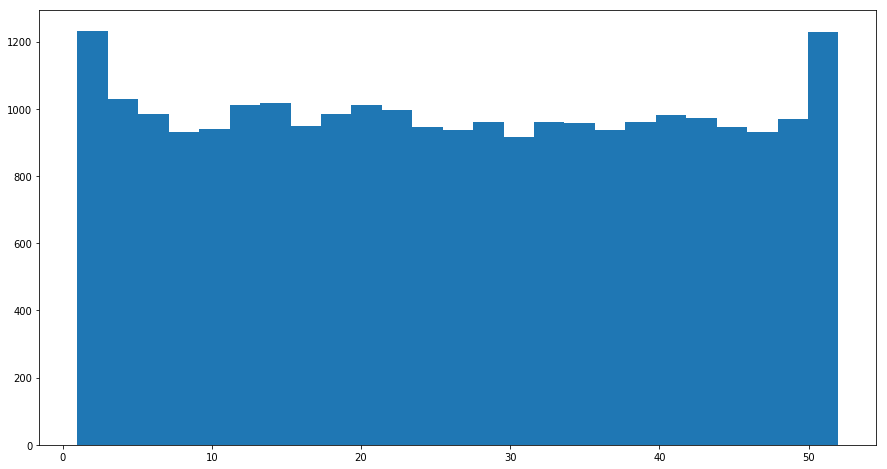

In [115]:
df['start_weeks_of_year'] = df['join_date'].dt.week
fig, ax = plt.subplots(figsize= (15,8))
plt.hist(df.start_weeks_of_year, bins=25)
plt.show()

In [116]:
# hiring peak at new year and year end

In [117]:
# Classify to two clusters - early quitter(quit within 400 days after joining the company) and quiter after 400 days
df['early_quiter'] = np.where(df['days'] < 400, 1, 0)

In [119]:
dummies =pd.get_dummies(df['dept'])
df =pd.concat([df,dummies], axis =1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 17 columns):
employee_id            24702 non-null float64
company_id             24702 non-null int64
dept                   24702 non-null object
seniority              24702 non-null int64
salary                 24702 non-null float64
join_date              24702 non-null datetime64[ns]
quit_date              24702 non-null datetime64[ns]
days                   24702 non-null int64
weeks_of_year          24702 non-null int64
start_weeks_of_year    24702 non-null int64
early_quiter           24702 non-null int64
customer_service       24702 non-null uint8
data_science           24702 non-null uint8
design                 24702 non-null uint8
engineer               24702 non-null uint8
marketing              24702 non-null uint8
sales                  24702 non-null uint8
dtypes: datetime64[ns](2), float64(2), int64(6), object(1), uint8(6)
memory usage: 2.2+ MB


In [120]:
X = df[['company_id', 'seniority', 'salary', 'customer_service', 'data_science', 'design', 'engineer', 'marketing', 'sales']]
y = df['early_quiter']


In [140]:
#build decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [141]:
features = list(X.columns)

In [142]:
g= export_graphviz(clf, out_file=None, feature_names=features, class_names=['Not early quitter', 'early quitter' ], 
                                filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(g)

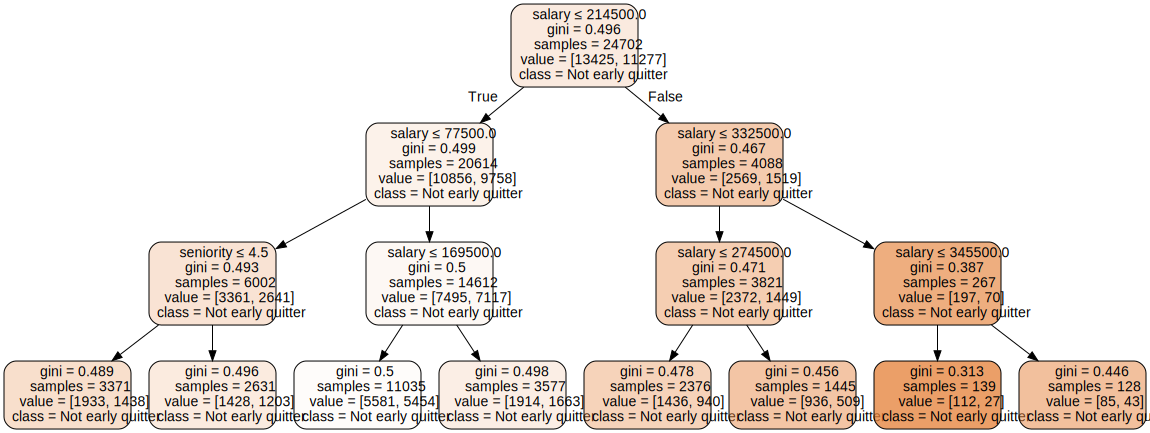

In [143]:
graph

## Insight: Salary is important in employee's choices of quitting
People makes a lot of money ( >= 214500) and less money (<77500) are not likely to quit early

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 17 columns):
employee_id            24702 non-null float64
company_id             24702 non-null int64
dept                   24702 non-null object
seniority              24702 non-null int64
salary                 24702 non-null float64
join_date              24702 non-null datetime64[ns]
quit_date              24702 non-null datetime64[ns]
days                   24702 non-null int64
weeks_of_year          24702 non-null int64
start_weeks_of_year    24702 non-null int64
early_quiter           24702 non-null int64
customer_service       24702 non-null uint8
data_science           24702 non-null uint8
design                 24702 non-null uint8
engineer               24702 non-null uint8
marketing              24702 non-null uint8
sales                  24702 non-null uint8
dtypes: datetime64[ns](2), float64(2), int64(6), object(1), uint8(6)
memory usage: 2.2+ MB


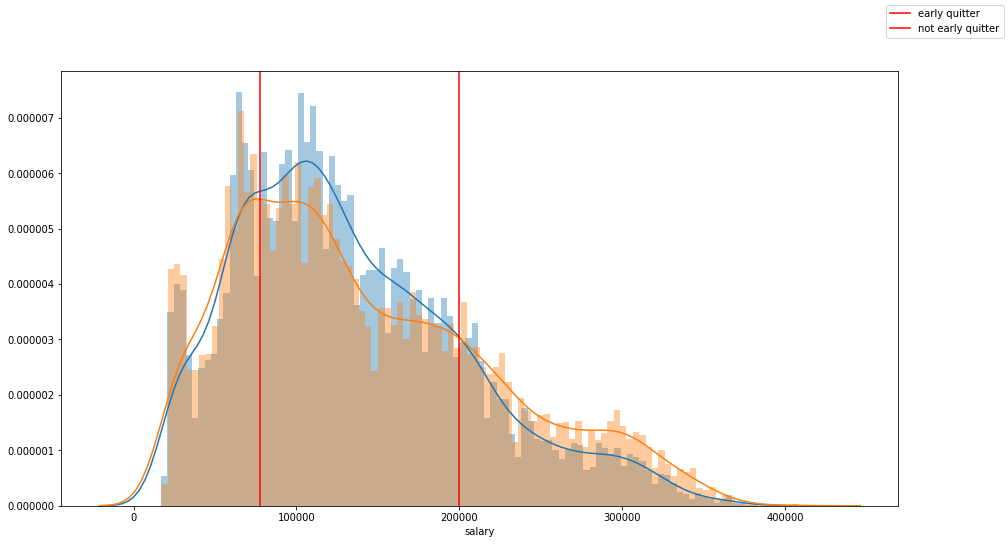

In [155]:
fig, ax = plt.subplots(figsize = (15,8))
sns.distplot(df[df['early_quiter'] ==1]['salary'], bins =100)
sns.distplot(df[df['early_quiter'] ==0]['salary'], bins =100)
plt.axvline(x=200000, color = 'red')
plt.axvline(x=77500, color = 'red')
fig.legend(labels=['early quitter','not early quitter'])

When salary is less than 77500, the salary is not an important factor when employees are considering of quitting early;

When salary is higher than 77500, the distribution of salary for two groups are different

Insights from book:
1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.
2. The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.
3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.